# Face Detection

Numerous well-known algorithms exist for finding and identifying faces in photos. One of the fastest and most popular algorithms for detecting faces in photos stems from a paper published in 2001 entitled [Rapid Object Detection using a Boosted Cascade of Simple Features](https://www.merl.com/publications/docs/TR2004-043.pdf). Sometimes known as Viola-Jones (the authors of the paper), the algorithm keys on the relative intensities of adjacent blocks of pixels.

Another common way to detect faces in photographs relies on deep learning. While more computationally expensive, deep-learning methods often do a better job of detecting faces in images than Viola-Jones. In particular, multitask cascaded convolutional neural networks, or MTCNNs, have proven adept at face detection in a variety of benchmarks. They also identify facial landmarks such as the eyes, the nose, and the mouth. MTCNNs were introduced in a 2016 paper entitled [Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks](https://arxiv.org/abs/1604.02878).

![](Images/winsummit.png)

The open-source [OpenCV](https://opencv.org/) library contains a handy implementation of Viola-Jones, while a Python package named [MTCNN](https://pypi.org/project/mtcnn/) provides an easy-to-use MTCNN implementation. Let's try both and see how they compare when it comes to detecting faces in photos.

## Viola-Jones

OpenCV provides an implementation of Viola-Jones in its [`CascadeClassifier`](https://docs.opencv.org/3.4.3/d1/de5/classcv_1_1CascadeClassifier.html) class, along with an XML file containing a cascade classifier trained to detect faces. Load an image and use `CascadeClassifier` to detect faces in it. Then draw rectangles around the faces:

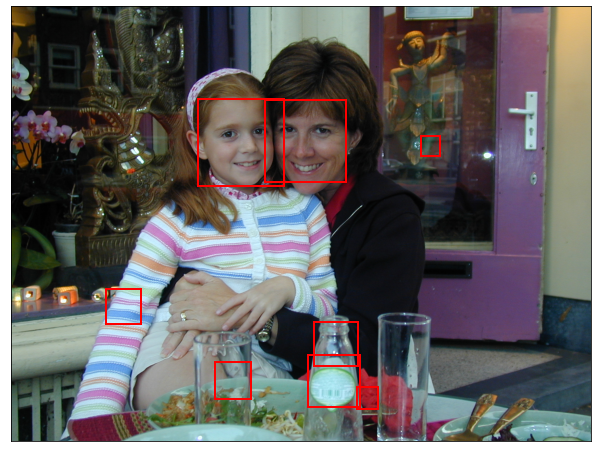

In [1]:
import cv2
from cv2 import CascadeClassifier
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline
 
image = plt.imread('Data/Amsterdam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
 
model = CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = model.detectMultiScale(image)
 
for face in faces:
    x, y, w, h = face
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

`CascadeClassifier` detected the two faces in the photo, but it also suffered a number of false positives. One way to mitigate that is to use the `minNeighbors` parameter. It defaults to 3, but higher values make `CascadeClassifier` more selective. Call `detectMultiScale` again with with `minNeighbors`=20:

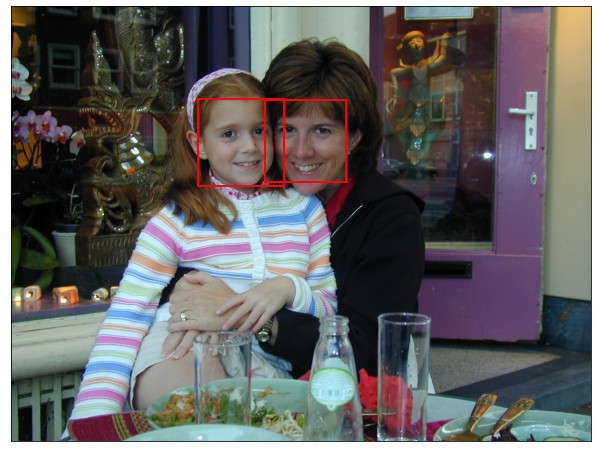

In [2]:
image = plt.imread('Data/Amsterdam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
 
model = CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = model.detectMultiScale(image, minNeighbors=20)
 
for face in faces:
    x, y, w, h = face
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

`CascadeClassifier` frequently requires tuning in this manner to strike the right balance between finding too many faces and finding too few. With that in mind, it is among the fastest face-detection algorithms in existence. It can also be used to detect objects other than faces by loading XML files containing [other pretrained classifiers](https://github.com/opencv/opencv/tree/master/data/lbpcascades). In [OpenCV’s GitHub repo](https://github.com/opencv/opencv), you’ll find XML files for detecting objects using Haar-like features, and XML files that detect objects using a different type of discriminator called local binary patterns.

## MTCNN

An MTCNN uses three CNNs arranged in series to detect faces. The first CNN, called the *Proposal Network*, or P-Net, is a shallow CNN that searches the image at various resolutions looking for features that might be indicative of faces. Rectangles identified by P-Net are combined to form candidate face rectangles and input to the *Refine Network*, or R-Net, which is a deeper CNN that examines those rectangles more closely and rejects those that lack faces. Finally, output from R-Net is input to the *Output Network* (O-Net), which further filters candidate rectangles and identifies facial landmarks in rectangles that make it through the filter.

Use the following statements to detect faces in the same photo featured in the previous example:

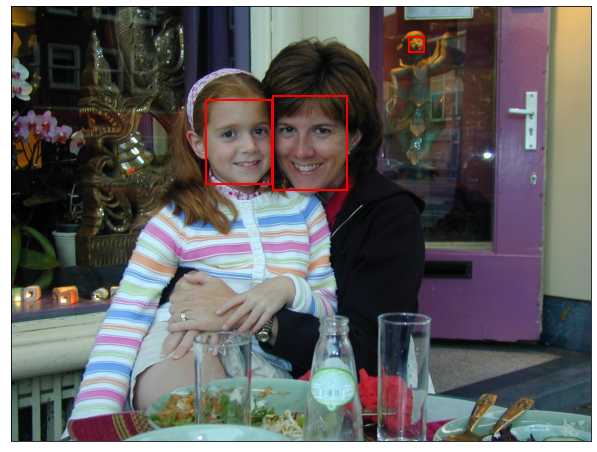

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
%matplotlib inline
 
image = plt.imread('Data/Amsterdam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
 
detector = MTCNN()
faces = detector.detect_faces(image)
 
for face in faces:
    x, y, w, h = face['box']
    rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

MTCNN not only detected the faces of my wife and daughter, but also the face of a statue reflected in the door behind them. Use the following statement to see what `detect_faces` returned: a list containing three dictionaries, each corresponding to one of the faces in the photo:

In [4]:
faces

[{'box': [723, 248, 204, 258],
  'confidence': 0.9997798800468445,
  'keypoints': {'left_eye': (765, 341),
   'right_eye': (858, 343),
   'nose': (800, 408),
   'mouth_left': (770, 432),
   'mouth_right': (864, 433)}},
 {'box': [538, 258, 183, 232],
  'confidence': 0.9997591376304626,
  'keypoints': {'left_eye': (601, 353),
   'right_eye': (685, 344),
   'nose': (662, 394),
   'mouth_left': (614, 433),
   'mouth_right': (689, 424)}},
 {'box': [1099, 84, 40, 41],
  'confidence': 0.8863282203674316,
  'keypoints': {'left_eye': (1108, 101),
   'right_eye': (1123, 96),
   'nose': (1116, 102),
   'mouth_left': (1114, 115),
   'mouth_right': (1127, 111)}}]

You can eliminate the face in the reflection in either of two ways: by ignoring faces with a confidence level below a certain threshold, or by passing a `min_face_size` parameter to the `MTCNN` function so `detect_faces` ignore faces smaller than a specified size. Use the former to ignore faces detected with a confidence level less than 90%:

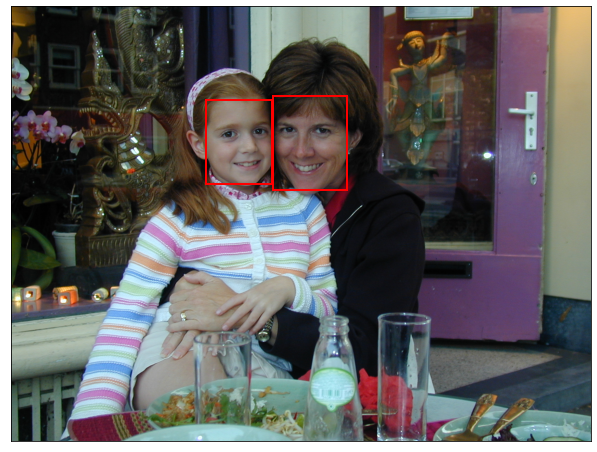

In [5]:
image = plt.imread('Data/Amsterdam.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)
 
detector = MTCNN()
faces = detector.detect_faces(image)
 
for face in faces:
    if face['confidence'] > 0.9:
        x, y, w, h = face['box']
        rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
        ax.add_patch(rect)

Once you know how to find faces in photos, it’s a simple matter to extract facial images so you can use them to train a model or submit them to a trained model for identification. Here's a Python function that accepts a path to an image file and returns a list of facial images. By default, it crops facial images so that they’re square (perfect for passing them to a CNN), but you can disable cropping by passing the function a `crop`=False parameter. You can also specify a minimum confidence level with a min_confidence parameter, which defaults to 0.9:

In [6]:
import numpy as np
from PIL import Image, ImageOps
from mtcnn.mtcnn import MTCNN
 
def extract_faces(input_file, min_confidence=0.9, crop=True):
    # Load the image and orient it correctly
    pil_image = Image.open(input_file)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]

    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    image = np.array(pil_image)
     
    # Find the faces in the image
    detector = MTCNN()
    faces = detector.detect_faces(image)
    faces = [face for face in faces if face['confidence'] >= min_confidence]
    results = []
     
    for face in faces:
        x1, y1, w, h = face['box']
 
        if (crop):
            # Compute crop coordinates
            if w > h:
                x1 = x1 + ((w - h) // 2)
                w = h
            elif h > w:
                y1 = y1 + ((h - w) // 2)
                h = w
 
        # Extract the facial image and add it to the list
        x2 = x1 + w
        y2 = y1 + h
        results.append(Image.fromarray(image[y1:y2, x1:x2]))
 
    # Return all the facial images
    return results

The faces extracted from an image are Python Imaging Library (PIL) images, so you can resize them or save them to disk with a single line of code. The following example extracts all the faces from a photo, resizes them to 224x224 pixels, and saves the resized images:

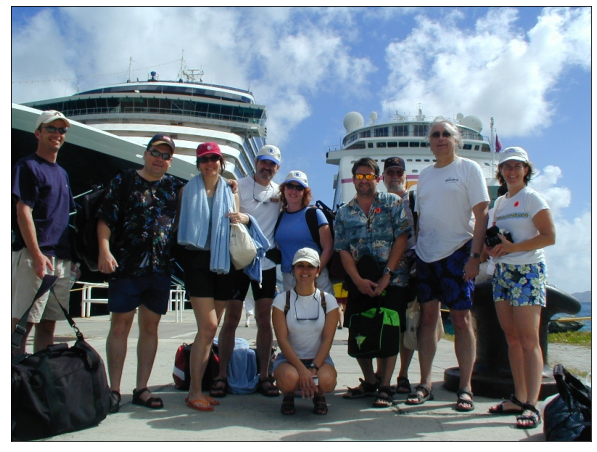

In [7]:
image = plt.imread('Data/cruise.jpg')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

faces = extract_faces('Data/cruise.jpg')
 
for i, face in enumerate(faces):
    face.resize((224, 224)).save(f'Data/face{i}.jpg')

Look in the "Data" subdirectory and you'll see the numbered facial images.